In [19]:
#Synthetic Data
import pandas as pd
import numpy as np
import random

# 1. Load Headers
try:
    df_orig = pd.read_csv('Survey on student expenses in University.csv')
    headers = df_orig.columns.tolist()
except FileNotFoundError:
    # Use your fallback headers
    headers = ['Timestamp', 'Gender', 'Year', 'Level', 'Field', 'Living', 'Scholarship', 'Loan', 'Allowance', 'Work', 'PartTimeIncome', 'Laptop', 'EatOut', 'ShopFreq', 'Track', 'Conscious', 'FoodWeekly', 'TransportWeekly', 'AccomPeriod', 'AccomCost', 'AcademicMonthly', 'InternetMonthly', 'EstimatedTotal']

# === 📊 CONFIGURATION: REAL DATA BOUNDARIES (FROM PILOT n=24) ===
REAL_MIN_ALLOWANCE = 0
REAL_MAX_ALLOWANCE = 1000

REAL_MIN_FOOD_WEEKLY = 6
REAL_MAX_FOOD_WEEKLY = 200

REAL_MIN_ACAD_MONTHLY = 0
REAL_MAX_ACAD_MONTHLY = 280

REAL_MIN_NET_MONTHLY = 0
REAL_MAX_NET_MONTHLY = 60

# ===============================================

data = []

# Choices (Same as before)
choices_gender = ["Male / Lelaki", "Female / Perempuan"]
choices_year = ["Year 1 / Tahun 1", "Year 2 / Tahun 2", "Year 3 / Tahun 3", "Year 4 or above / Tahun 4 atau ke atas"]
choices_level = ["Diploma", "Bachelor's Degree / Ijazah Sarjana Muda", "Master's / Sarjana", "PhD / Kedoktoran"]
choices_field = ["Computer Science / Sains Komputer", "Agriculture / Pertanian", "Others / Lain-lain"]
choices_living = ["With family / Tinggal bersama keluarga", "On-campus hostel / Asrama dalam kampus", "Off-campus rented house / Rumah sewa luar kampus"]
choices_yesno = ["Yes / Ya", "No / Tidak"]
choices_eat = ["Often (daily) / Kerap (setiap hari)", "Sometimes (3–6 times/week) / Kadang-kadang (3–6 kali/minggu)", "Rarely (0–2 times/week) / Jarang (0–2 kali/minggu)"]
choices_shop = ["Frequently / Kerap", "Occasionally / Sekali-sekala", "Rarely / Jarang"]

# Indices Helper
def get_col_index(keywords):
    for i, h in enumerate(headers):
        if all(k.lower() in h.lower() for k in keywords):
            return i
    return -1

idx_food = get_col_index(["food", "week"])
idx_transport = get_col_index(["transport", "week"])
idx_accom_period = get_col_index(["period", "accommodation"])
idx_accom_cost = get_col_index(["pay", "accommodation", "RM"])
idx_academic = get_col_index(["academic", "materials"])
idx_internet = get_col_index(["internet", "phone"])
idx_total_est = get_col_index(["estimate", "total", "monthly"])

print("Generating empirically grounded synthetic data...")

np.random.seed(42)  
random.seed(42)

for _ in range(500):
    row = [""] * len(headers)
    
    # 1. Persona Score
    lifestyle_score = np.clip(np.random.normal(0.5, 0.2), 0, 1)

    # 2. Chaos Factors
    is_splurger = np.random.rand() < 0.10 
    is_saver = False
    if not is_splurger:
        is_saver = np.random.rand() < 0.15

    # --- Standard Columns (Gender, Year, etc) ---
    row[0] = "Synthetic_Grounded"
    row[1] = np.random.choice(choices_gender, p=[0.75, 0.25])
    row[2] = np.random.choice(choices_year, p=[0.1, 0.4, 0.3, 0.2])
    row[3] = np.random.choice(choices_level, p=[0.3, 0.6, 0.05, 0.05])
    row[4] = np.random.choice(choices_field, p=[0.6, 0.1, 0.3])

    # Living
    # Low distance roll  
    distance_roll = np.random.rand()
    
    if distance_roll < 0.60:
        if lifestyle_score < 0.3: 
            living = "On-campus hostel / Asrama dalam kampus"
        else:
            living = "Off-campus rented house / Rumah sewa luar kampus"
            
    elif distance_roll > 0.80:
        if lifestyle_score > 0.85:
            living = "Off-campus rented house / Rumah sewa luar kampus"
        elif lifestyle_score > 0.4:
            living = "On-campus hostel / Asrama dalam kampus"
        else:
            living = "With family / Tinggal bersama keluarga"
            
    else:
        if lifestyle_score > 0.7:
            living = "Off-campus rented house / Rumah sewa luar kampus"
        elif lifestyle_score > 0.3:
            living = "On-campus hostel / Asrama dalam kampus"
        else:
            living = "With family / Tinggal bersama keluarga"
            
    row[5] = living
    row[6] = random.choice(choices_yesno) # Scholarship
    row[7] = random.choice(choices_yesno) # Loan

    # --- 💰 ALLOWANCE (Interpolated) ---
    # Logic: Min + (Score * (Max - Min))
    allowance_range = REAL_MAX_ALLOWANCE - REAL_MIN_ALLOWANCE
    base_allowance = REAL_MIN_ALLOWANCE + (lifestyle_score * allowance_range)
    
    # Add noise
    allowance = int(max(REAL_MIN_ALLOWANCE, base_allowance + np.random.normal(0, 150)))
    row[8] = allowance

    # Work & Income
    work = np.random.choice(choices_yesno, p=[0.2, 0.8])
    row[9] = work
    income = 0
    if work == "Yes / Ya":
        income = int(max(100, np.random.normal(500, 150)))
    row[10] = income

    # Laptop
    prob_laptop = 0.20 + (lifestyle_score * 0.70) 
    if "Computer" in row[4]:
        prob_laptop = 0.70 + (lifestyle_score * 0.20) 
    row[11] = "Yes / Ya" if np.random.rand() < prob_laptop else "No / Tidak"

    # Eat Out Freq
    
    if "family" in living:
        # Living with Family = Mom cooks = Low Eat Out probability
        if is_splurger: 
            # Even if rich, mom's food is best, but treats themselves
            eat_probs = [0.3, 0.4, 0.3] 
        elif is_saver:  
            # Almost never eats out
            eat_probs = [0.05, 0.15, 0.8] 
        else:           
            # Average student with family
            eat_probs = [0.1, 0.3, 0.6]

    elif "hostel" in living:
        # Hostel = Can't cook = HIGH Eat Out probability (Necessity)
        if is_splurger: 
            eat_probs = [0.8, 0.15, 0.05]
        elif is_saver:  
            # Wants to save, but hard to cook. Maybe eats Maggi?
            # Still forced to eat out more than family students
            eat_probs = [0.3, 0.5, 0.2] 
        else:           
            eat_probs = [0.6, 0.3, 0.1]

    else: # Rental (Off-campus)
        # Rental = Can cook, but optional. Strongly linked to Lifestyle.
        if is_splurger: 
            eat_probs = [0.7, 0.2, 0.1]
        elif is_saver:  
            # Cooks to save money
            eat_probs = [0.1, 0.4, 0.5] 
        else:           
            eat_probs = [0.3, 0.5, 0.2]
            
    row[12] = np.random.choice(choices_eat, p=eat_probs)

    # Shop Freq
    if is_splurger: 
        shop_probs = [0.7, 0.2, 0.1]
    elif is_saver:  
        shop_probs = [0.05, 0.15, 0.8]
    elif lifestyle_score > 0.7: 
        shop_probs = [0.4, 0.4, 0.2]
    elif lifestyle_score > 0.4: 
        shop_probs = [0.2, 0.5, 0.3]
    else: 
        shop_probs = [0.1, 0.2, 0.7]
        
    row[13] = np.random.choice(choices_shop, p=shop_probs)

    # Track & Conscious
    if is_saver: track = "Yes / Ya"
    elif is_splurger: track = "No / Tidak"
    elif lifestyle_score < 0.4: track = np.random.choice(choices_yesno, p=[0.6, 0.4])
    else: track = np.random.choice(choices_yesno, p=[0.3, 0.7])
    row[14] = track

    conscious_val = int(5 - (lifestyle_score * 4))

    if track == "Yes / Ya":
        conscious_val += 1
    else:
        conscious_val -= 1
        conscious_val = min(4, conscious_val) 
    
    if is_saver: conscious_val += 1
    if is_splurger: conscious_val -= 1
    
    conscious_val = max(1, min(5, conscious_val + np.random.randint(-1, 2)))
    row[15] = conscious_val

    # --- 💸 FINANCIALS (Interpolated) ---

    # 1. FOOD WEEKLY
    food_range = REAL_MAX_FOOD_WEEKLY - REAL_MIN_FOOD_WEEKLY
    base_food = REAL_MIN_FOOD_WEEKLY + (lifestyle_score * food_range)
    
    if is_splurger: base_food *= 1.3
    if is_saver: base_food *= 0.8
    
    food_weekly = int(max(REAL_MIN_FOOD_WEEKLY, np.random.normal(base_food, 20)))
    if idx_food != -1: row[idx_food] = food_weekly

    # 2. TRANSPORT WEEKLY
    if "rented" in living:
        base_trans = 30 + (lifestyle_score * 40)
    elif "family" in living:
        base_trans = 20 + (lifestyle_score * 20)
    else:
        base_trans = 10 
    if is_splurger: base_trans += 20
    transport_weekly = int(max(0, np.random.normal(base_trans, 10)))
    if idx_transport != -1: row[idx_transport] = transport_weekly

    # 3. ACCOMMODATION
    accom_monthly_equivalent = 0
    if "family" in living:
        accom_period = "I do not pay for accommodation / Saya tidak bayar untuk penginapan"
        accom_cost = 0
    elif "hostel" in living:
        accom_period = "Semester payment / Bayaran semester"
        accom_cost = int(np.random.normal(700, 200)) 
        accom_monthly_equivalent = accom_cost / 4
    else: # Rental
        accom_period = "Monthly payment / Bayaran bulanan"
        rent_cost = 90 + (lifestyle_score * 300)
        accom_cost = int(np.random.normal(rent_cost, 90))
        accom_monthly_equivalent = accom_cost
    if idx_accom_period != -1: row[idx_accom_period] = accom_period
    if idx_accom_cost != -1: row[idx_accom_cost] = accom_cost

    # 4. ACADEMIC & INTERNET (Interpolated)
    acad_range = REAL_MAX_ACAD_MONTHLY - REAL_MIN_ACAD_MONTHLY
    base_academic = REAL_MIN_ACAD_MONTHLY + (lifestyle_score * acad_range)
    if is_splurger: base_academic += 20
    
    academic_monthly = int(max(REAL_MIN_ACAD_MONTHLY, np.random.normal(base_academic, 10)))
    if idx_academic != -1: row[idx_academic] = academic_monthly

    net_range = REAL_MAX_NET_MONTHLY - REAL_MIN_NET_MONTHLY
    base_internet = REAL_MIN_NET_MONTHLY + (lifestyle_score * net_range)
    
    internet_monthly = int(max(REAL_MIN_NET_MONTHLY, np.random.normal(base_internet, 5)))
    if idx_internet != -1: row[idx_internet] = internet_monthly

    # 5. ESTIMATED TOTAL
    real_total = (food_weekly * 4) + (transport_weekly * 4) + accom_monthly_equivalent + academic_monthly + internet_monthly
    
    if conscious_val >= 4 and track == "Yes / Ya":
        error_factor = np.random.uniform(0.95, 1.10) 
    else:
        error_factor = np.random.uniform(0.35, 1.55) 
    
    estimated_total = int(round((real_total * error_factor) / 10.0) * 10)
    if idx_total_est != -1: row[idx_total_est] = estimated_total

    data.append(row)

# Save
df_new = pd.DataFrame(data, columns=headers)
df_combined = pd.concat([df_orig, df_new], ignore_index=True)
df_combined.to_csv('final_student_expenses_combined.csv', index=False)

print(f"✅ Success! Generated 500 rows bounded by real data ranges.")

Generating empirically grounded synthetic data...
✅ Success! Generated 500 rows bounded by real data ranges.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#df = pd.read_csv('Survey on student expenses in University.csv')
df = pd.read_csv('final_student_expenses_combined.csv')

df.head()

,Timestamp,Gender\n\nJantina,Year of study\n\nTahun pengajian,Level of study\n\nPeringkat pengajian,Field of study\n\nBidang pengajian\n,Living arrangement\n\nTempat tinggal,Do you receive any scholarship or financial aid?\n\nAdakah anda menerima biasiswa atau bantuan kewangan?,"Do you have a student loan (e.g., PTPTN)\n\nAdakah anda mempunyai hutang pelajar? (cth., PTPTN)",How much total allowance do you receive from parents/guardians per month (RM)?\n\nBerapa jumlah elaun yang anda terima daripada ibu bapa/penjaga setiap bulan (RM)?,Do you work part-time?\n\nAdakah anda bekerja sambilan?,"If you have a part-time job, how much do you earn per month (RM)? (If none, enter 0)\n\nJika anda bekerja sambilan, berapa pendapatan anda setiap bulan (RM)? (Jika tiada, masukkan 0)",Do you have your own laptop?\n\nAdakah anda mempunyai komputer riba sendiri?,How often do you eat outside (restaurants/cafes)?\n\nSeberapa kerap anda makan di luar (restoran/kafe)?,"How often do you shop for non-essential items (new clothes, gadgets, etc.)?\n\nBerapa kerap anda membeli-belah untuk barangan bukan keperluan (pakaian baru, gajet, dan lain-lain)?",Do you track or record your expenses regularly?\n\nAdakah anda merekod atau menjejak perbelanjaan anda secara berkala?\n,"Please rate your agreement with the following statement:\n""I am very conscious of my spending and try to control it.""\n\nSila nilaikan persetujuan anda dengan pernyataan berikut: \n""Saya sangat sedar tentang perbelanjaan saya dan cuba mengawalnya.""",How much do you spend on food each week (RM)?\n\nBerapa perbelanjaan makanan anda setiap minggu (RM)?,How much do you spend on transport each week (RM)?\n\nBerapa perbelanjaan pengangkutan anda setiap minggu (RM)?,What time period does your accommodation payment cover?\n\nApakah tempoh masa yang meliputi bayaran penginapan anda?,"How much do you pay for accommodation or hostel (RM)? (If you live with family and pay 0, please enter 0) *\n\nBerapa bayaran penginapan atau asrama anda (RM)?","How much do you spend on academic materials (books, printing, stationery) per month (RM)?\n\nBerapa perbelanjaan bahan akademik (buku, cetakan, alat tulis) anda setiap bulan (RM)?",How much do you spend on internet/phone bills per month (RM)?\n\nBerapa perbelanjaan bil internet/telefon anda setiap bulan (RM)?,What do you estimate your total monthly expense (RM)? \n\nBerapa anggaran jumlah perbelanjaan bulanan anda (RM)?
0,11/15/2025 17:35:53,Male / Lelaki,Year 2 / Tahun 2,Diploma,Others / Lain-lain,With family / Tinggal bersama keluarga,Yes / Ya,No,0,Yes / Ya,360,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,6,5,I do not pay for accommodation / Saya tidak ba...,0,10,60,80
1,11/15/2025 17:41:06,Male / Lelaki,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,On-campus hostel / Asrama dalam kampus,Yes / Ya,Yes,0,No / Tidak,0,Yes / Ya,Often (daily) / Kerap (setiap hari),Occasionally / Sekali-sekala,No / Tidak,5,70,0,One-time payment for the semester / Bayaran se...,420,5,20,500
2,11/15/2025 17:42:52,Female / Perempuan,Year 2 / Tahun 2,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,No / Tidak,No,200,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,Yes / Ya,5,35,5,I do not pay for accommodation / Saya tidak ba...,0,0,40,400
3,11/15/2025 19:12:24,Male / Lelaki,Year 1 / Tahun 1,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,Yes / Ya,No,300,No / Tidak,0,Yes / Ya,Sometimes (3–6 times/week) / Kadang-kadang (3–...,Rarely / Jarang,Yes / Ya,5,20,10,I do not pay for accommodation / Saya tidak ba...,0,50,35,400
4,11/18/2025 10:22:32,Female / Perempuan,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,Off-campus rented house / Rumah sewa luar kampus,No / Tidak,No,500,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasio

In [21]:

# 1. Rename Columns 
# Mapping the long raw questions to short variable names
df.rename(columns={
    'Gender\n\nJantina': 'Gender',
    'Year of study\n\nTahun pengajian': 'Year',
    'Level of study\n\nPeringkat pengajian': 'Level',
    'Field of study\n\nBidang pengajian\n': 'Field',
    'Living arrangement\n\nTempat tinggal': 'Living',
    'Do you receive any scholarship or financial aid?\n\nAdakah anda menerima biasiswa atau bantuan kewangan?': 'Scholarship',
    'Do you have a student loan (e.g., PTPTN)\n\nAdakah anda mempunyai hutang pelajar?  (cth., PTPTN)': 'Loan',
    'How much total allowance do you receive from parents/guardians per month (RM)?\n\nBerapa jumlah elaun yang anda terima daripada ibu bapa/penjaga setiap bulan (RM)?': 'Allowance',
    'Do you work part-time?\n\nAdakah anda bekerja sambilan?': 'Work',
    'If you have a part-time job, how much do you earn per month (RM)? (If none, enter 0)\n\nJika anda bekerja sambilan, berapa pendapatan anda setiap bulan (RM)? (Jika tiada, masukkan 0)': 'PartTimeIncome',
    'Do you have your own laptop?\n\nAdakah anda mempunyai komputer riba sendiri?': 'Laptop',
    'How often do you eat outside (restaurants/cafes)?\n\nSeberapa kerap anda makan di luar (restoran/kafe)?': 'EatOut',
    'How often do you shop for non-essential items (new clothes, gadgets, etc.)?\n\nBerapa kerap anda membeli-belah untuk barangan bukan keperluan (pakaian baru, gajet, dan lain-lain)?': 'ShopNonEssential',
    'Do you track or record your expenses regularly?\n\nAdakah anda merekod atau menjejak perbelanjaan anda secara berkala?\n': 'TrackExpenses',
    'Please rate your agreement with the following statement:\n"I am very conscious of my spending and try to control it."\n\nSila nilaikan persetujuan anda dengan pernyataan berikut: \n"Saya sangat sedar tentang perbelanjaan saya dan cuba mengawalnya."': 'Conscious',
    'How much do you spend on food each week (RM)?\n\nBerapa perbelanjaan makanan anda setiap minggu (RM)?': 'FoodWeekly',
    'How much do you spend on transport each week (RM)?\n\nBerapa perbelanjaan pengangkutan anda setiap minggu (RM)?': 'TransportWeekly',
    'What time period does your accommodation payment cover?\n\nApakah tempoh masa yang meliputi bayaran penginapan anda?': 'AccomPeriod',
    'How much do you pay for accommodation or hostel (RM)? (If you live with family and pay 0, please enter 0) *\n\nBerapa bayaran penginapan atau asrama anda (RM)?': 'AccomCost',
    'How much do you spend on academic materials (books, printing, stationery) per month (RM)?\n\nBerapa perbelanjaan bahan akademik (buku, cetakan, alat tulis) anda setiap bulan (RM)?': 'AcademicMonthly',
    'How much do you spend on internet/phone bills per month (RM)?\n\nBerapa perbelanjaan bil internet/telefon anda setiap bulan (RM)?': 'InternetMonthly',
    'What do you estimate your total monthly expense (RM)? \n\nBerapa anggaran jumlah perbelanjaan bulanan anda (RM)? ': 'EstimatedTotal'
}, inplace=True)

df.head()


,Timestamp,Gender,Year,Level,Field,Living,Scholarship,Loan,Allowance,Work,PartTimeIncome,Laptop,EatOut,ShopNonEssential,TrackExpenses,Conscious,FoodWeekly,TransportWeekly,AccomPeriod,AccomCost,AcademicMonthly,InternetMonthly,EstimatedTotal
0,11/15/2025 17:35:53,Male / Lelaki,Year 2 / Tahun 2,Diploma,Others / Lain-lain,With family / Tinggal bersama keluarga,Yes / Ya,No,0,Yes / Ya,360,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,6,5,I do not pay for accommodation / Saya tidak ba...,0,10,60,80
1,11/15/2025 17:41:06,Male / Lelaki,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,On-campus hostel / Asrama dalam kampus,Yes / Ya,Yes,0,No / Tidak,0,Yes / Ya,Often (daily) / Kerap (setiap hari),Occasionally / Sekali-sekala,No / Tidak,5,70,0,One-time payment for the semester / Bayaran se...,420,5,20,500
2,11/15/2025 17:42:52,Female / Perempuan,Year 2 / Tahun 2,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,No / Tidak,No,200,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,Yes / Ya,5,35,5,I do not pay for accommodation / Saya tidak ba...,0,0,40,400
3,11/15/2025 19:12:24,Male / Lelaki,Year 1 / Tahun 1,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,Yes / Ya,No,300,No / Tidak,0,Yes / Ya,Sometimes (3–6 times/week) / Kadang-kadang (3–...,Rarely / Jarang,Yes / Ya,5,20,10,I do not pay for accommodation / Saya tidak ba...,0,50,35,400
4,11/18/2025 10:22:32,Female / Perempuan,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,Off-campus rented house / Rumah sewa luar kampus,No / Tidak,No,500,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,100,50,I do not pay for accommodation / Saya tidak ba...,300,50,0,500


In [22]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Timestamp         524 non-null    object
 1   Gender            524 non-null    object
 2   Year              524 non-null    object
 3   Level             524 non-null    object
 4   Field             524 non-null    object
 5   Living            524 non-null    object
 6   Scholarship       524 non-null    object
 7   Loan              524 non-null    object
 8   Allowance         524 non-null    int64 
 9   Work              524 non-null    object
 10  PartTimeIncome    524 non-null    int64 
 11  Laptop            524 non-null    object
 12  EatOut            524 non-null    object
 13  ShopNonEssential  524 non-null    object
 14  TrackExpenses     524 non-null    object
 15  Conscious         524 non-null    int64 
 16  FoodWeekly        524 non-null    int64 
 17  TransportWeekly 

In [23]:

# Rule 1: If Cost > 0 but they said "I do not pay", assume they misclicked the text.
mask_fix_1 = (df['AccomCost'] > 0) & (df['AccomPeriod'].str.contains("not pay", case=False))
print(f"Fixing {mask_fix_1.sum()} rows who pay money but selected 'No Pay'...")
df.loc[mask_fix_1, 'AccomPeriod'] = "Monthly payment / Bayaran bulanan"

# Rule 2: If Cost == 0 but they said "Monthly/Semester", assume they actually don't pay.
mask_fix_2 = (df['AccomCost'] == 0) & (df['AccomPeriod'].str.contains("Monthly", case=False))
print(f"Fixing {mask_fix_2.sum()} rows who pay RM 0 but selected 'Monthly'...")
df.loc[mask_fix_2, 'AccomPeriod'] = "I do not pay for accommodation / Saya tidak bayar untuk penginapan"


# 2. Standardize Accommodation
def calculate_monthly_rent(row):
    cost = row['AccomCost']
    period = row['AccomPeriod']
    if 'semester' in str(period).lower():
        return cost / 4 
    else:
        return cost

df['AccommodationMonthly']  = df.apply(calculate_monthly_rent, axis=1)

# 3. Calculate CTME (Creating the Target Variable)
# Weekly * 4.33 to get Monthly
df['FoodMonthly'] = df['FoodWeekly'] * 4.33
df['TransportMonthly'] = df['TransportWeekly'] * 4.33
df['CTME'] = (
    df['FoodMonthly'] + 
    df['TransportMonthly'] + 
    df['AccommodationMonthly'] + 
    df['AcademicMonthly'] + 
    df['InternetMonthly']
)


df.info()

Fixing 2 rows who pay money but selected 'No Pay'...
Fixing 1 rows who pay RM 0 but selected 'Monthly'...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             524 non-null    object 
 1   Gender                524 non-null    object 
 2   Year                  524 non-null    object 
 3   Level                 524 non-null    object 
 4   Field                 524 non-null    object 
 5   Living                524 non-null    object 
 6   Scholarship           524 non-null    object 
 7   Loan                  524 non-null    object 
 8   Allowance             524 non-null    int64  
 9   Work                  524 non-null    object 
 10  PartTimeIncome        524 non-null    int64  
 11  Laptop                524 non-null    object 
 12  EatOut                524 non-null    object 
 13  ShopNonEssential   

Generating 'AFTER' Graphs...


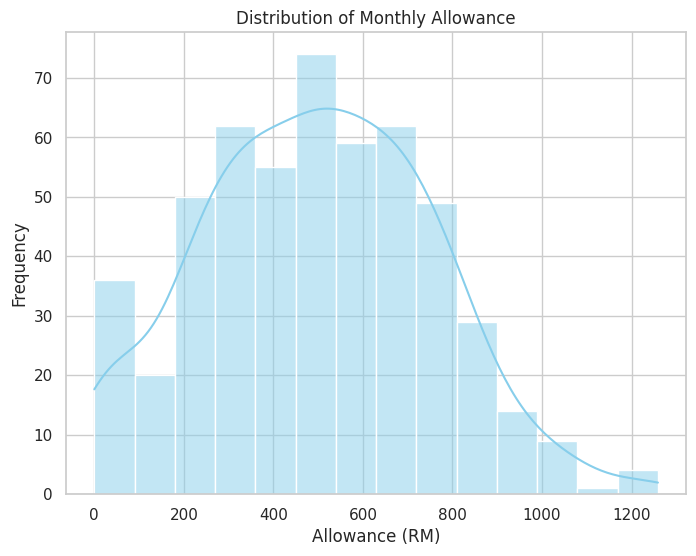

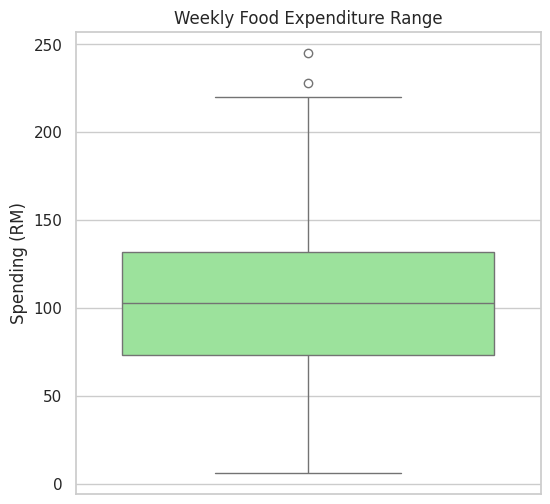

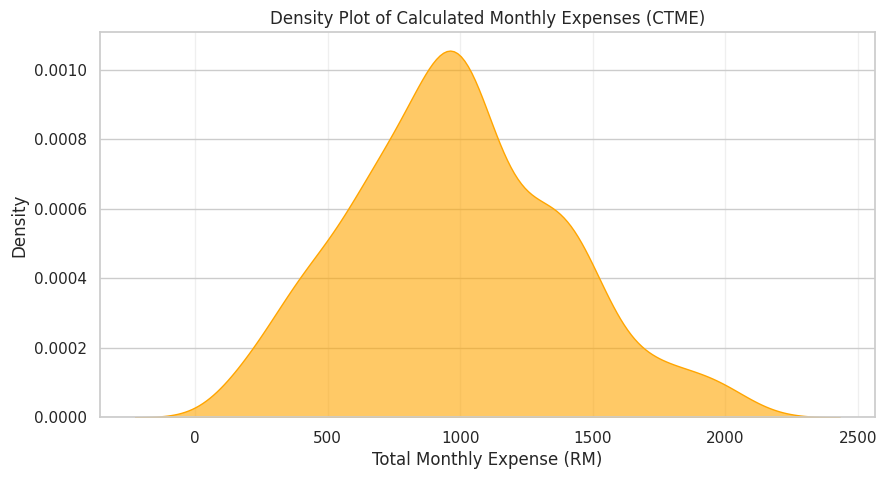

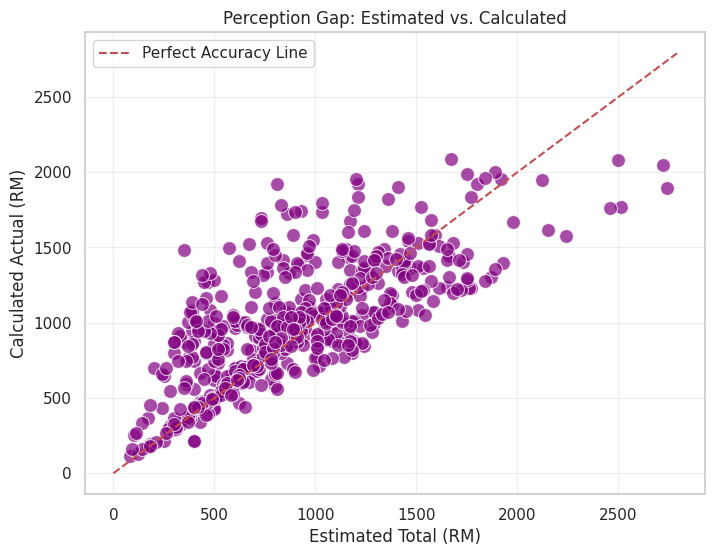

In [24]:

# ==============================================================================
# SECTION 3: THE "AFTER" GRAPHS (Cleaned & Processed)
# ==============================================================================
print("Generating 'AFTER' Graphs...")

# --- AFTER Graph 1: Allowance (Cleaned Label) ---
plt.figure(figsize=(8, 6))
sns.histplot(df['Allowance'], kde=True, color='skyblue')
plt.title('Distribution of Monthly Allowance') # Added clear title
plt.xlabel('Allowance (RM)') # Added clear short label
plt.ylabel('Frequency')

plt.savefig("postprocess_1.png", dpi=300, bbox_inches="tight")
plt.show()


# --- AFTER Graph 2: Food Spending (Cleaned Label) ---
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['FoodWeekly'], color='lightgreen')
plt.title('Weekly Food Expenditure Range')
plt.ylabel('Spending (RM)')

plt.savefig("postprocess_2.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Graph 3: CTME Distribution (Impossible without preprocessing) ---
plt.figure(figsize=(10, 5))
sns.kdeplot(df['CTME'], fill=True, color='orange', alpha=0.6)
plt.title("Density Plot of Calculated Monthly Expenses (CTME)")
plt.xlabel("Total Monthly Expense (RM)")
plt.ylabel("Density")
plt.grid(axis='x', alpha=0.3)
plt.savefig("postprocess_3.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Graph 4: Perception Gap (Impossible without preprocessing) ---
plt.figure(figsize=(8, 6))

sns.scatterplot(x='EstimatedTotal', y='CTME', data=df, s=100, color='purple', alpha=0.7)

# Add Reference Line (Ideal scenario where Estimate = Actual)
limit = max(df['CTME'].max(), df['EstimatedTotal'].max()) + 50
plt.plot([0, limit], [0, limit], 'r--', label='Perfect Accuracy Line')

plt.title('Perception Gap: Estimated vs. Calculated')
plt.xlabel('Estimated Total (RM)')
plt.ylabel('Calculated Actual (RM)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig("postprocess_4.png", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_102269/925527990.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_copy, x='TrackExpenses', ax=axes[1], palette="viridis", order=['Yes', 'No'])
/tmp/ipykernel_102269/925527990.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_copy, y='Field', ax=axes[2], palette="magma", order=df_copy['Field'].value_counts().index)


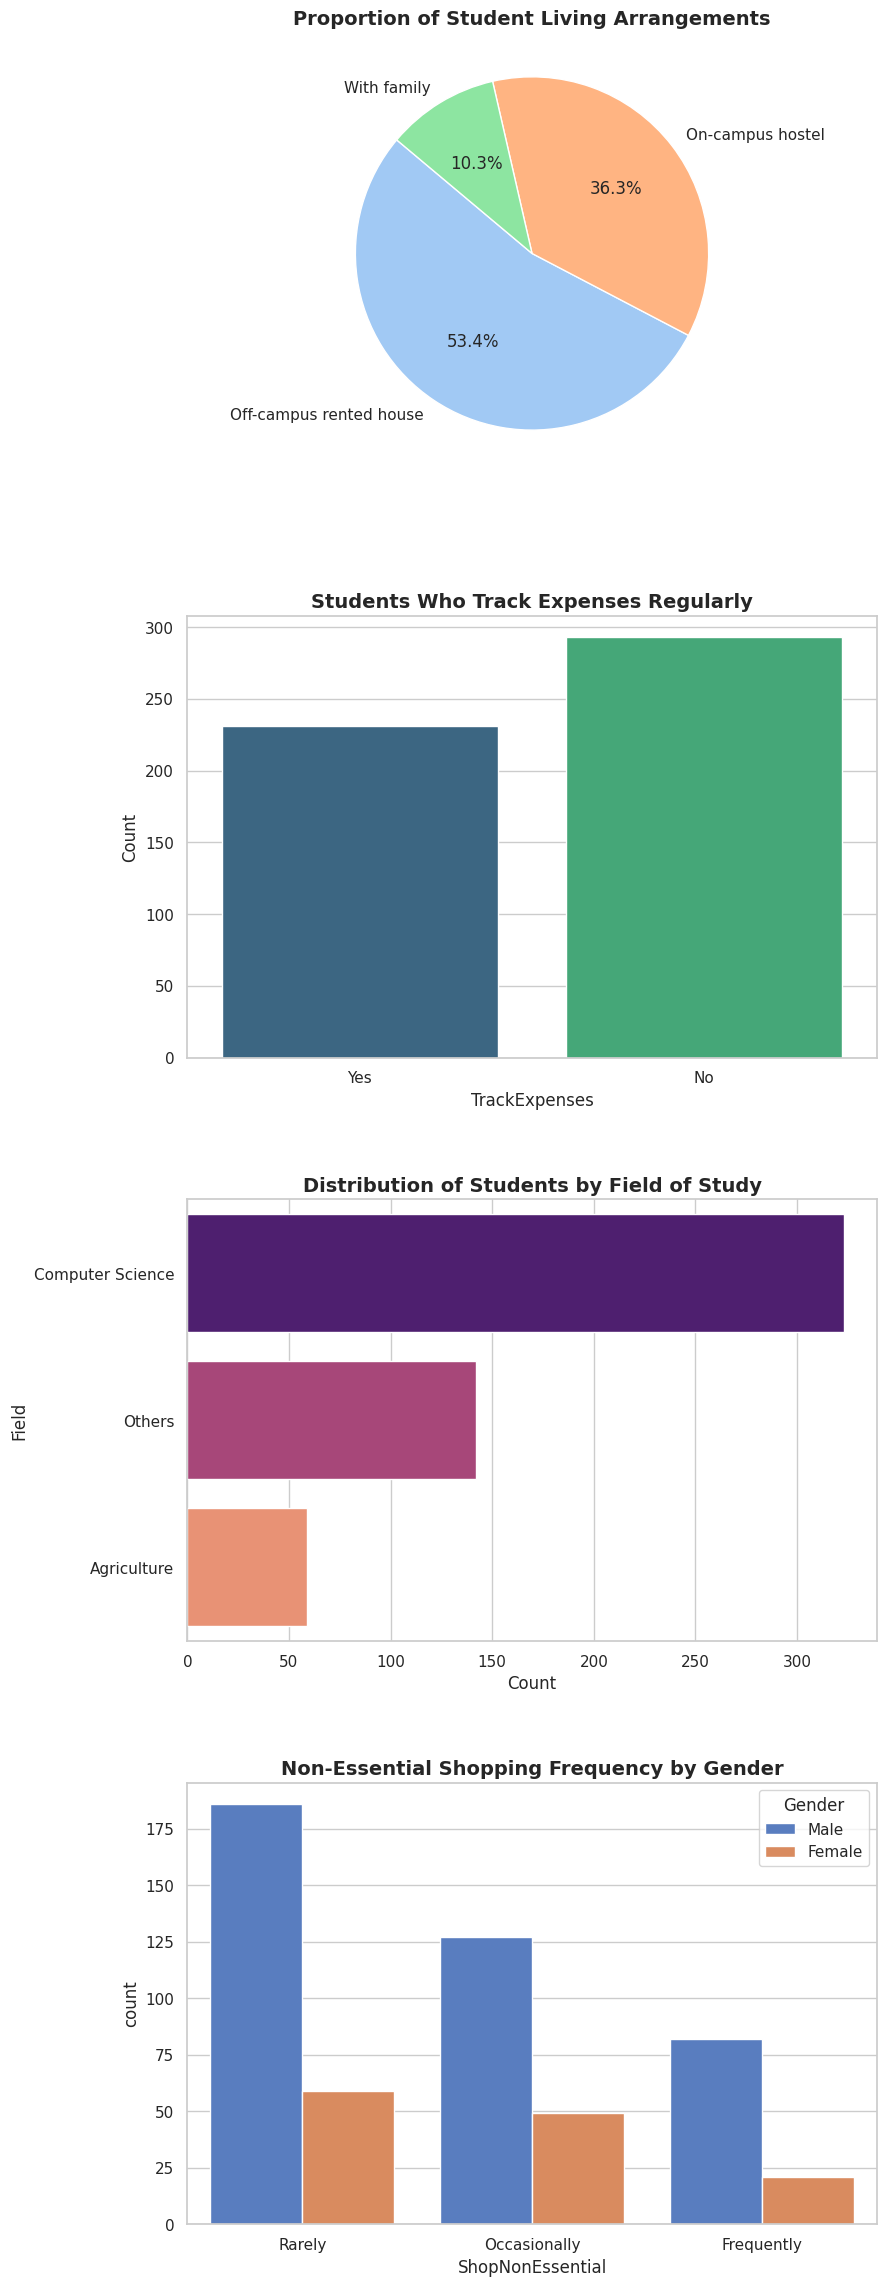

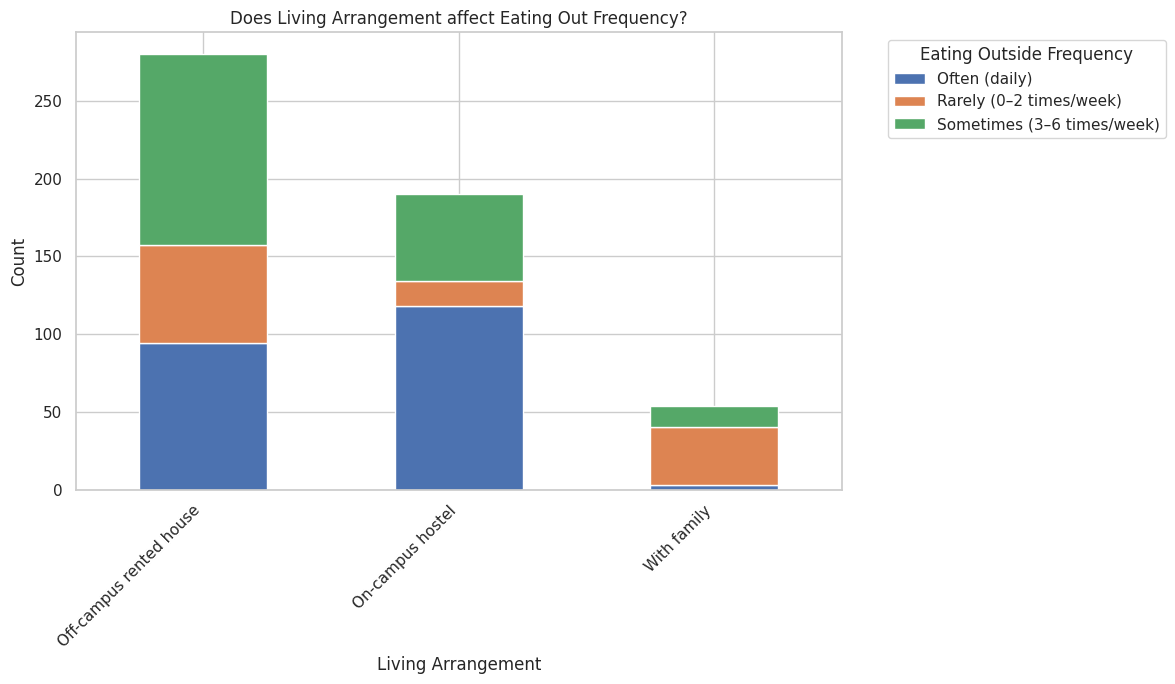

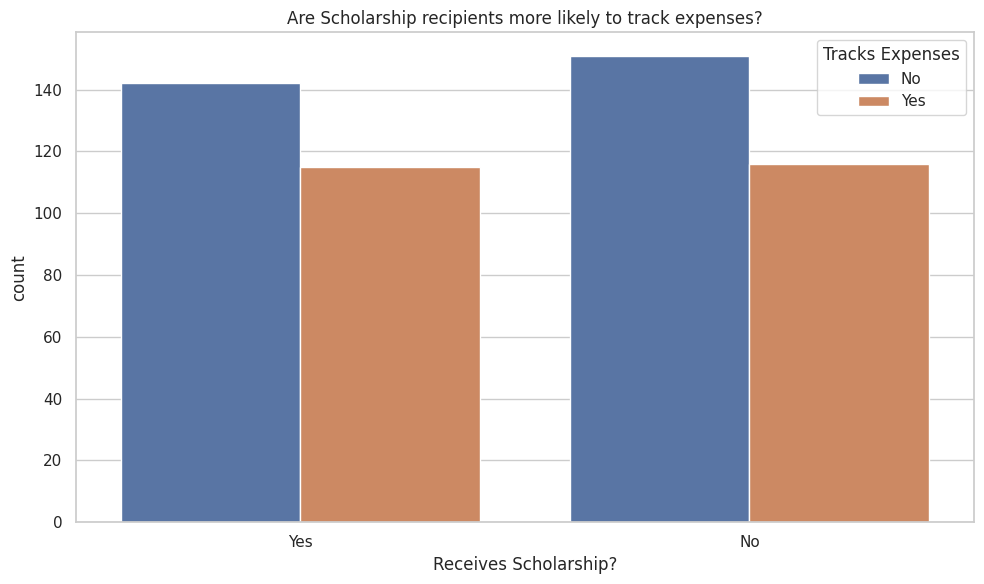

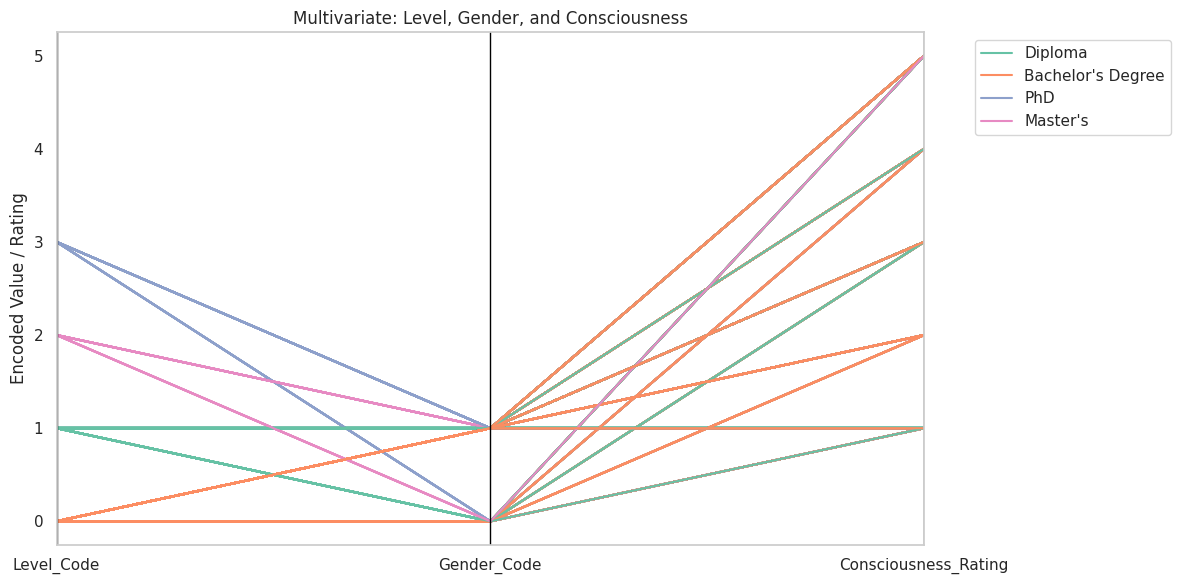

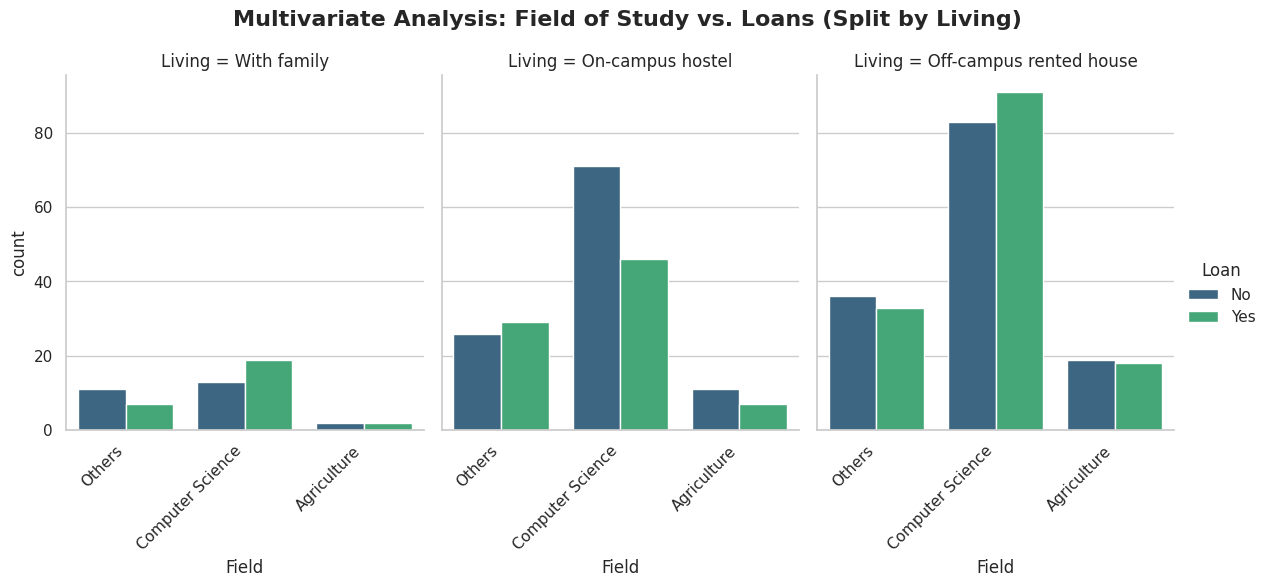

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

df_copy = df.copy();
cols_to_clean = ['Gender', 'Year', 'Level', 'Field', 'Living', 'Scholarship', 'Loan', 'Work', 'Laptop', 'EatOut', 'ShopNonEssential', 'TrackExpenses']
for col in cols_to_clean:
    if col in df.columns:
        df_copy[col] = df_copy[col].astype(str).str.split(' / ').str[0].str.strip()

# Set style
sns.set_theme(style="whitegrid")

# --- VISUALIZATION SET 1 (General) ---
fig1, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 24))

# 1. Living Arrangement
acc_counts = df_copy['Living'].value_counts()
axes[0].pie(acc_counts, labels=acc_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
axes[0].set_title('Proportion of Student Living Arrangements', fontsize=14, fontweight='bold')

# 2. Expense Tracking
sns.countplot(data=df_copy, x='TrackExpenses', ax=axes[1], palette="viridis", order=['Yes', 'No'])
axes[1].set_title('Students Who Track Expenses Regularly', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')

# 3. Field of Study
sns.countplot(data=df_copy, y='Field', ax=axes[2], palette="magma", order=df_copy['Field'].value_counts().index)
axes[2].set_title('Distribution of Students by Field of Study', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Count')

# 4. Shopping Frequency
shopping_order = ['Rarely', 'Occasionally', 'Frequently']
sns.countplot(data=df_copy, x='ShopNonEssential', hue='Gender', ax=axes[3], palette="muted", order=shopping_order)
axes[3].set_title('Non-Essential Shopping Frequency by Gender', fontsize=14, fontweight='bold')

plt.tight_layout(pad=4.0)
fig1.savefig("general_categorical.png", dpi=300, bbox_inches="tight")
plt.show()

# --- VISUALIZATION SET 2 (Advanced) ---

# 5. Stacked Bar: Living vs EatOut
plt.figure(figsize=(12, 7))
ct1 = pd.crosstab(df_copy['Living'], df_copy['EatOut'])
ct1.plot(kind='bar', stacked=True, figsize=(12, 7), ax=plt.gca())
plt.title('Does Living Arrangement affect Eating Out Frequency?')
plt.xlabel('Living Arrangement')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Eating Outside Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("adv_categorical_1.png", dpi=300, bbox_inches="tight")
plt.show()

# 6. Grouped Bar: Scholarship vs Tracking
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='Scholarship', hue='TrackExpenses')
plt.title('Are Scholarship recipients more likely to track expenses?')
plt.xlabel('Receives Scholarship?')
plt.legend(title='Tracks Expenses')
plt.tight_layout()
plt.savefig("adv_categorical_2.png", dpi=300, bbox_inches="tight")
plt.show()

# 7. Parallel Coordinates (Using Copy)
df_copy['Level_Code'] = df_copy['Level'].astype('category').cat.codes
df_copy['Gender_Code'] = df_copy['Gender'].astype('category').cat.codes
df_copy['Consciousness_Rating'] = pd.to_numeric(df_copy['Conscious'], errors='coerce')

plt.figure(figsize=(12, 6))
parallel_coordinates(df_copy[['Level_Code', 'Gender_Code', 'Consciousness_Rating', 'Level']], 
                     'Level', color=sns.color_palette("Set2"))
plt.title('Multivariate: Level, Gender, and Consciousness')
plt.ylabel('Encoded Value / Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("adv_categorical_3.png", dpi=300, bbox_inches="tight")
plt.show()

# 8. REPLACEMENT: Faceted Count Plot
# Replaces the confusing 3D scatter with a clear visual of volume and relationship
g = sns.catplot(
    data=df_copy, 
    x='Field', 
    hue='Loan', 
    col='Living',
    kind='count',
    height=5, 
    aspect=0.8,
    palette='viridis'
)
g.set_xticklabels(rotation=45, ha='right')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Multivariate Analysis: Field of Study vs. Loans (Split by Living)', fontsize=16, fontweight='bold')
g.savefig("adv_categorical_4_replacement.png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
df.drop(columns=['FoodWeekly'], inplace=True);
df.drop(columns=['TransportWeekly'], inplace=True);

In [27]:
# The columns that are Yes/No questions
binary_cols = ['Scholarship', 'Loan', 'Work', 'Laptop', 'TrackExpenses']

for col in binary_cols:
    # This looks for "Yes" inside the string (handling "Yes / Ya" automatically)
    df[col] = df[col].astype(str).str.contains('Yes', case=False).astype(int)
    
# Check the results
print(df[binary_cols].head())

   Scholarship  Loan  Work  Laptop  TrackExpenses
0            1     0     1       1              0
1            1     1     0       1              0
2            0     0     0       1              1
3            1     0     0       1              1
4            0     0     0       1              0


In [28]:
# 1. Helper function to clean "Year" and "Level"
def clean_year(val):
    val = str(val)
    if '1' in val: return 0
    if '2' in val: return 1
    if '3' in val: return 2
    if '4' in val: return 3
    return 1 # Fallback or handle as appropriate

def clean_level(val):
    val = str(val).lower()
    if 'diploma' in val: return 0
    if 'degree' in val or 'bachelor' in val: return 1
    if 'master' in val: return 2
    if 'phd' in val: return 3
    return 1 # Fallback

# 2. Helper function to clean Frequency (Never -> Daily)
def clean_frequency(val):
    val = str(val).lower()
    if 'rarely' in val or 'jarang' in val: return 0
    if 'occasionally' in val or 'sometimes' in val or 'kadang' in val: return 1
    if 'frequently' in val or 'often' in val or 'kerap' in val: return 2
    return 1 # Fallback

# APPLY THEM
df['Year'] = df['Year'].apply(clean_year)
df['Level'] = df['Level'].apply(clean_level)
df['EatOut'] = df['EatOut'].apply(clean_frequency)
df['ShopNonEssential'] = df['ShopNonEssential'].apply(clean_frequency)

In [29]:
import pandas as pd

# 1. CLEAN THE TEXT FIRST (Crucial Step)
# We map the long messy strings to short, simple codes.
# This ensures your final columns are named "Male", "Hostel", "Rental", etc.
cleanup_map = {
    # Gender
    'Male / Lelaki': 'Male',
    'Female / Perempuan': 'Female',
    
    # Living
    'On-campus hostel / Asrama dalam kampus': 'Hostel',
    'Off-campus rented house / Rumah sewa luar kampus': 'Rental',
    'With family / Tinggal bersama keluarga': 'Family',
    
    # Field
    'Computer Science / Sains Komputer': 'CS',
    'Others / Lain-lain': 'OtherField',
    'Agriculture / Pertanian': 'Agriculture'
}

# Apply the cleaning (Use replace to be safe)
cols_to_clean = ['Gender', 'Living', 'Field']
for col in cols_to_clean:
    # This replaces the long text with the short text defined above
    df[col] = df[col].replace(cleanup_map)

dummies = []
nominal_cols = ['Gender', 'Living', 'Field']

for col in nominal_cols:
    # get_dummies on a single Series creates columns named after the values
    # drop_first=True prevents the "Dummy Variable Trap" (essential for regression)
    dummy = pd.get_dummies(df[col], drop_first=True, dtype=int)
    dummies.append(dummy)

# Concatenate all the new dummy columns to the main dataframe
df = pd.concat([df] + dummies, axis=1)

# Drop the original text columns
df.drop(columns=nominal_cols, inplace=True)

# 3. VERIFY
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             524 non-null    object 
 1   Year                  524 non-null    int64  
 2   Level                 524 non-null    int64  
 3   Scholarship           524 non-null    int64  
 4   Loan                  524 non-null    int64  
 5   Allowance             524 non-null    int64  
 6   Work                  524 non-null    int64  
 7   PartTimeIncome        524 non-null    int64  
 8   Laptop                524 non-null    int64  
 9   EatOut                524 non-null    int64  
 10  ShopNonEssential      524 non-null    int64  
 11  TrackExpenses         524 non-null    int64  
 12  Conscious             524 non-null    int64  
 13  AccomPeriod           524 non-null    object 
 14  AccomCost             524 non-null    int64  
 15  AcademicMonthly       5

In [30]:
df.drop(columns=['Timestamp'], inplace=True)
df.drop(columns=['AccomPeriod', 'AccomCost'], inplace=True)

In [31]:
# Check info - Dtype should contain ONLY int64 or float64
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  524 non-null    int64  
 1   Level                 524 non-null    int64  
 2   Scholarship           524 non-null    int64  
 3   Loan                  524 non-null    int64  
 4   Allowance             524 non-null    int64  
 5   Work                  524 non-null    int64  
 6   PartTimeIncome        524 non-null    int64  
 7   Laptop                524 non-null    int64  
 8   EatOut                524 non-null    int64  
 9   ShopNonEssential      524 non-null    int64  
 10  TrackExpenses         524 non-null    int64  
 11  Conscious             524 non-null    int64  
 12  AcademicMonthly       524 non-null    int64  
 13  InternetMonthly       524 non-null    int64  
 14  EstimatedTotal        524 non-null    int64  
 15  AccommodationMonthly  5

In [32]:
# Set option to display all columns (None means unlimited)
pd.set_option('display.max_columns', None)

# Now, df.head() will show all columns
print(df.head(5))

   Year  Level  Scholarship  Loan  Allowance  Work  PartTimeIncome  Laptop  \
0     1      0            1     0          0     1             360       1   
1     2      1            1     1          0     0               0       1   
2     1      0            0     0        200     0               0       1   
3     0      0            1     0        300     0               0       1   
4     2      1            0     0        500     0               0       1   

   EatOut  ShopNonEssential  TrackExpenses  Conscious  AcademicMonthly  \
0       0                 1              0          4               10   
1       2                 1              0          5                5   
2       0                 1              1          5                0   
3       1                 0              1          5               50   
4       0                 1              0          4               50   

   InternetMonthly  EstimatedTotal  AccommodationMonthly  FoodMonthly  \
0            

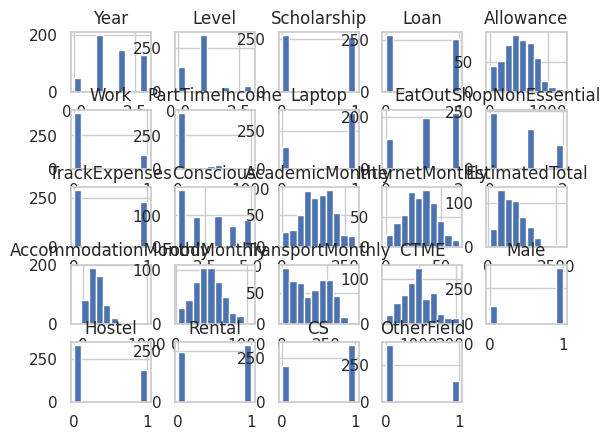

In [33]:
# histograms
df.hist()
plt.show()

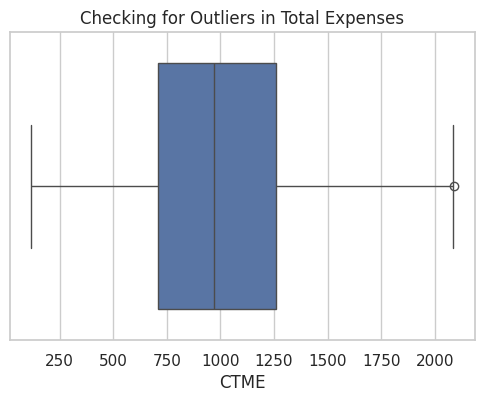

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Target Variable (CTME) to see if anyone is way off
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['CTME'])
plt.title("Checking for Outliers in Total Expenses")
plt.show()

In [35]:
# Calculate the "Fence" to find outliers
Q1 = df['CTME'].quantile(0.25)
Q3 = df['CTME'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (standard is 1.5 times IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outlier rows
outliers = df[(df['CTME'] < lower_bound) | (df['CTME'] > upper_bound)]
print(f"🗑️ Removing {len(outliers)} outlier(s):")
print(outliers[['CTME']])

# Filter the dataframe to keep only GOOD rows
df = df[(df['CTME'] >= lower_bound) & (df['CTME'] <= upper_bound)]

print(f"✅ New dataset size: {len(df)} rows")

🗑️ Removing 1 outlier(s):
       CTME
74  2088.35
✅ New dataset size: 523 rows


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forbidden = ['CTME', 'EstimatedTotal', 'AccommodationMonthly', 'FoodMonthly', 'TransportMonthly', 'InternetMonthly', 'AcademicMonthly']

# 1. Define your Features (X) and Target (y)
# Drop the target columns from X so the model doesn't cheat!
# We also drop 'EstimatedTotal' because that's just the student's guess
y = df['CTME']
X = df.drop(columns=forbidden)

# 2. Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

print("✅ Model trained successfully!")

train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")


predictions = model.predict(X_test)

# 1. Calculate the metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # RMSE is just the square root of MSE
r2 = r2_score(y_test, predictions)

# 2. Print them clearly
print(f"---DATA TEST--")
print(f"📉 MAE  (Mean Absolute Error): RM {mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {r2:.4f}")

# This will be the baseline

✅ Model trained successfully!
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 155.66
💥 RMSE (Root Mean Sq Error): RM 197.00
📊 R²   (Fit Score 0-1):      0.7467
---DATA TEST--
📉 MAE  (Mean Absolute Error): RM 162.54
💥 RMSE (Root Mean Sq Error): RM 213.83
📊 R²   (Fit Score 0-1):      0.7420


In [38]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Scale
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)


train_pred = model_scaled.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

print(f"Feature Scaling Results:")
print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")

# 4. Predict
preds_scaled = model_scaled.predict(X_test_scaled)

# 5. Get Metrics (FIXED HERE)
mae_scaled = mean_absolute_error(y_test, preds_scaled)
mse_scaled = mean_squared_error(y_test, preds_scaled) # Get MSE first
rmse_scaled = np.sqrt(mse_scaled)                     # Calculate RMSE manually
r2_scaled = r2_score(y_test, preds_scaled)

print(f"---DATA TEST--")
print(f"MAE:  RM {mae_scaled:.2f}")
print(f"RMSE: RM {rmse_scaled:.2f}")
print(f"R²:   {r2_scaled:.4f}")

Feature Scaling Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 155.66
💥 RMSE (Root Mean Sq Error): RM 197.00
📊 R²   (Fit Score 0-1):      0.7467
---DATA TEST--
MAE:  RM 162.54
RMSE: RM 213.83
R²:   0.7420


In [45]:
# Check correlations again, ignoring the "Cheating" columns
corrs = df.corr()['CTME'].sort_values(ascending=False)
valid_corrs = corrs.drop(labels=forbidden, errors='ignore')

print("Top Valid Predictors:")
print(valid_corrs.head(20))

Top Valid Predictors:
Allowance           0.715756
Rental              0.604367
ShopNonEssential    0.316950
EatOut              0.106591
Level               0.088447
Year                0.066548
Scholarship         0.063347
Laptop              0.054826
Loan                0.042252
PartTimeIncome      0.028971
Work                0.010792
Male                0.010169
CS                  0.008750
OtherField         -0.042441
TrackExpenses      -0.292508
Hostel             -0.329253
Conscious          -0.519800
Name: CTME, dtype: float64


In [50]:
# 1. Select ONLY the best features 
features_selected = [
    'Allowance', 
    'ShopNonEssential', 
    'EatOut',           
    'Conscious', 
    'TrackExpenses', 
    'Hostel', 
    'Rental'
]

X_sel = df[features_selected]
y_sel = df['CTME']

# 2. Split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.2, random_state=42)


train_df = X_train_sel.copy()
train_df['CTME'] = y_train_sel
train_df.to_csv('split_dataset_train.csv', index=False)

test_df = X_test_sel.copy()
test_df['CTME'] = y_test_sel
test_df.to_csv('split_dataset_test.csv', index=False)

print("✅ Saved 'split_dataset_train.csv' and 'split_dataset_test.csv'")

X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

# 3. Train
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train_sel)

print(f"\nFeature Selection Results:")
train_pred = model_sel.predict(X_train_sel)
train_mae = mean_absolute_error(y_train_sel, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_sel, train_pred))
train_r2 = r2_score(y_train_sel, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")

# 4. Predict
preds_sel = model_sel.predict(X_test_sel)

# 5. Metrics (FIXED HERE)
mae_sel = mean_absolute_error(y_test_sel, preds_sel)
mse_sel = mean_squared_error(y_test_sel, preds_sel)
rmse_sel = np.sqrt(mse_sel)
r2_sel = r2_score(y_test_sel, preds_sel)

print(f"---DATA TEST--")
print(f"📉 MAE  (Mean Absolute Error): RM {mae_sel:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {rmse_sel:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {r2_sel:.4f}")

✅ Saved 'split_dataset_train.csv' and 'split_dataset_test.csv'

Feature Selection Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 160.97
💥 RMSE (Root Mean Sq Error): RM 203.13
📊 R²   (Fit Score 0-1):      0.7307
---DATA TEST--
📉 MAE  (Mean Absolute Error): RM 163.39
💥 RMSE (Root Mean Sq Error): RM 215.90
📊 R²   (Fit Score 0-1):      0.7370


In [51]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Define model & params
param_grid = {'alpha': [0.1, 1.0, 10, 50, 100]}
ridge = Ridge()

# 2. Setup Grid Search
# Note: scoring='neg_mean_absolute_error' tries to minimize MAE
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')

# 3. Fit on the SELECTED features (from your Step 2)
grid_search.fit(X_train_sel, y_train_sel)

# 4. Get best model
best_model = grid_search.best_estimator_
print(f"Best Alpha found: {grid_search.best_params_}")



print(f"\nHyperparameter Tuning Results:")
train_pred = best_model.predict(X_train_sel)
train_mae = mean_absolute_error(y_train_sel, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_sel, train_pred))
train_r2 = r2_score(y_train_sel, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")


# 5. Predict
preds_tuned = best_model.predict(X_test_sel)

# 6. Metrics (The Fix is here!)
mae_tuned = mean_absolute_error(y_test_sel, preds_tuned)


mse_tuned = mean_squared_error(y_test_sel, preds_tuned)
rmse_tuned = np.sqrt(mse_tuned)

r2_tuned = r2_score(y_test_sel, preds_tuned)

print(f"---DATA TEST--")
print(f"MAE:  RM {mae_tuned:.2f}")
print(f"RMSE: RM {rmse_tuned:.2f}")
print(f"R²:   {r2_tuned:.4f}")

Best Alpha found: {'alpha': 10}

Hyperparameter Tuning Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 161.06
💥 RMSE (Root Mean Sq Error): RM 203.45
📊 R²   (Fit Score 0-1):      0.7299
---DATA TEST--
MAE:  RM 164.07
RMSE: RM 216.51
R²:   0.7355


In [53]:
coef_df = pd.DataFrame({
    'Feature': features_selected,
    'Coefficient (RM)': best_model.coef_
})
print(coef_df)

            Feature  Coefficient (RM)
0         Allowance        181.699868
1  ShopNonEssential         52.265122
2            EatOut         11.077920
3         Conscious        -59.232247
4     TrackExpenses          3.060463
5            Hostel         62.997732
6            Rental        210.859260


In [54]:
from sklearn.pipeline import Pipeline

# 1. Use ONLY your Best Features
X_final = df[features_selected]
y_final = df['CTME']

# 2. Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 3. Create a Pipeline 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=10)) 
])

# 4. Train
pipeline.fit(X_train_f, y_train_f)

# 5. Predict
preds_final = pipeline.predict(X_test_f)

# 6. Score
print(f"FINAL COMBINED SCORE:")
print(f"MAE: RM {mean_absolute_error(y_test_f, preds_final):.2f}")
print(f"RMSE: RM {np.sqrt(mean_squared_error(y_test_f, preds_final)):.2f}")
print(f"R²:  {r2_score(y_test_f, preds_final):.4f}")

FINAL COMBINED SCORE:
MAE: RM 164.07
RMSE: RM 216.51
R²:  0.7355


In [55]:
import joblib

# 1. Create a dictionary to save both the model and the feature names
model_data = {
    "model": pipeline,        
    "features": features_selected 
}

# 2. Save it to a file
joblib.dump(model_data, "student_spending_model.pkl")

print("✅ Model saved as 'student_spending_model.pkl'")

✅ Model saved as 'student_spending_model.pkl'


In [57]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# --- LOAD MODEL ---
try:
    model_data = joblib.load("student_spending_model.pkl")
    model = model_data["model"]
    feature_names = model_data["features"]
except FileNotFoundError:
    st.error("Model file not found. Please train the model first!")
    st.stop()

st.set_page_config(page_title="Student Expense Predictor", page_icon="💸")

st.title("💸 Student Expense Predictor")
st.write("Predicts expenses based on these selected features!")

# --- SIDEBAR / INPUTS ---
with st.form("input_form"):
    col1, col2 = st.columns(2)
    
    with col1:
        # 1. Allowance
        allowance = st.number_input("Monthly Allowance from Parents/Guardians (RM)", min_value=0, value=300, step=50)
        
        # Living Arrangement
        living_options = ["With Family", "On-Campus Hostel", "Off-Campus Rental"]
        living = st.selectbox("Living Arrangement", living_options)
        
        # Shopping Frequency
        shop_map = {"Rarely": 0, "Occasionally": 1, "Frequently": 2}
        shop = st.selectbox("Shopping Frequency for Non-Essential", list(shop_map.keys()))
        shop_val = shop_map[shop]

        # Eating Out
        eat_map = {"Rarely": 0, "Sometimes": 1, "Often (daily)": 2}
        eat = st.selectbox("Eating Out Frequency", list(eat_map.keys()))
        eat_val = eat_map[eat]

    with col2:

          

        # Tracking
        track = st.radio("Do you track expenses?", ["No", "Yes"])
        track_val = 1 if track == "Yes" else 0
        
        # Consciousness
        conscious = st.slider("Financial Discipline (1-5)", 1, 5, 3)

    submit = st.form_submit_button("Predict Expenses")

# --- PREDICTION ---
if submit:
    is_hostel = 1 if living == "On-Campus Hostel" else 0
    is_rental = 1 if living == "Off-Campus Rental" else 0
    
    # Create Data Row
    input_data = {
        'ShopNonEssential': shop_val,
        'Allowance': allowance,
        'Hostel': is_hostel,
        'Rental': is_rental,
        'EatOut': eat_val,
        'TrackExpenses': track_val,
        'Conscious': conscious
    }
    
    # Convert to DF
    input_df = pd.DataFrame([input_data])
    input_df = input_df[feature_names] # Ensure order
    
    # Predict
    pred = model.predict(input_df)[0]
    
    # Result
    st.divider()
    st.success(f"💰 Predicted Monthly Expenses: **RM {pred:,.2f}**")
    

Overwriting app.py
